# Energy Resolution Calculation based on semi-empirical formula

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

$$ \frac{\sigma_{\langle E\rangle}}{{\langle E\rangle}} = \frac{\sqrt{F\cdot \langle E\rangle+  \frac{Q (1-e^{-t/\tau})}{e^{-t/\tau}} + \frac{Q^2}{(e^{-t/\tau})^2}\left(\frac{t}{\tau}\right)^2 \sigma_\tau^2 + \frac{\sigma^2_{Q,\mathrm{noise} }}{(e^{-t/\tau})^2}  + \frac{S}{\epsilon} \left[ (1-\epsilon) + \frac{\Lambda}{(1+\Lambda)^2} \right] + \frac{\mathrm{DC}+\eta_\mathrm{noise}}{\epsilon^2 (1+\Lambda)^2 } + S^2\sigma_{lm}^2 } }{{\langle E\rangle}} $$

## Constants

In [2]:
Fano = 1.0
CorrAv = 0.2 
ElecLifetime = 10.0 # in ms
PDE = 0.184
PTE = 0.332 
QValue = 2458000.0 # in eV
WValue = 11.5 # in eV
Quanta = QValue/WValue

## Functions

In [3]:
def GetLightNoise(PTE=0.3, PDE=0.2, CorrAv=0.2, Yield=0.04, LMapNoise=0.0, QValue=2458000): 
    Photons = QValue * Yield
    CollectionEff = PDE * PTE
    LightCollectionNoise = Photons / CollectionEff * (1 - CollectionEff)
    CorrelatedAvalancheNoise = Photons / CollectionEff * CorrAv / (1 + CorrAv)**2
    LightmapNoise = (Photons * LMapNoise)**2
    LightNoise = LightCollectionNoise + CorrelatedAvalancheNoise + LightmapNoise
    return LightNoise, LightCollectionNoise, CorrelatedAvalancheNoise, LightmapNoise

In [4]:
def GetChargeNoise(CurrentNoise=100, ElecLifetime=10.0, ElecLifetimeError=0.0, Yield=0.05, QValue=2458000): 
    Electrons = QValue * Yield
    DriftTime = 65.0 / 0.2 / 1000.0 # cm / cm/us = us
    ChargeNoiseLib = pd.read_csv('eventnoise_vs_currentnoise.csv', usecols=[0,1], header=None, names=['Current', 'Noise'])
    ElectronicsNoise = ChargeNoiseLib['Noise'].loc[ChargeNoiseLib['Current'] == CurrentNoise]
    ElectronicsNoise = ElectronicsNoise.to_numpy()[0]**2 / np.exp(-DriftTime/ElecLifetime)**2
    LifetimeNoise = Electrons * (1 - np.exp(-DriftTime/ElecLifetime)) / np.exp(-DriftTime/ElecLifetime)
    LifetimeSystematic = (Electrons / np.exp(-DriftTime/ElecLifetime) * DriftTime / ElecLifetime * ElecLifetimeError)**2
    ChargeNoise = ElectronicsNoise + LifetimeNoise + LifetimeSystematic
    return ChargeNoise, ElectronicsNoise, LifetimeNoise, LifetimeSystematic

In [5]:
def GetResolution(Noise, QValue=2458000.0, WValue=11.5):
    Quanta = QValue / WValue
    Resolution = np.sqrt(Noise) / Quanta * 100
    return Resolution

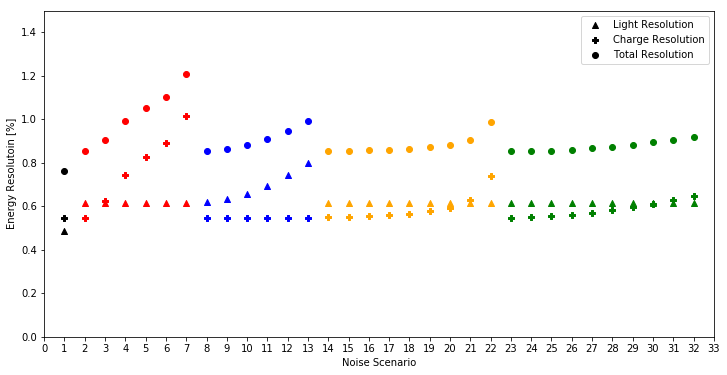

In [6]:
fig = plt.figure(figsize=(12,6))
plt.xticks(np.arange(0,40,1))
plt.xlabel('Noise Scenario')
plt.ylabel('Energy Resolutoin [%]')
plt.xlim(0,33)
plt.ylim(0,1.5)

NoiseTerms = {}
NoiseTerms['Light'],_,_,_ = GetLightNoise(PTE=0.337, PDE=0.283, CorrAv=CorrAv)
NoiseTerms['Charge'],_,_,_ = GetChargeNoise(CurrentNoise=100)
plt.scatter(1, GetResolution(NoiseTerms['Light']), marker='^', color='k')
plt.scatter(1, GetResolution(NoiseTerms['Charge']), marker='P', color='k')
plt.scatter(1, GetResolution(NoiseTerms['Charge'] + NoiseTerms['Light'] + Fano * Quanta), marker='o', color='k')

NoiseTerms['Light'],_,_,_ = GetLightNoise(PTE=0.332, PDE=0.184, CorrAv=CorrAv)
Offset = 2
for ii in range(6):
    X = ii + Offset
    CurrentNoise = 100 + ii*20
    NoiseTerms['Charge'],_,_,_ = GetChargeNoise(CurrentNoise=CurrentNoise)
    plt.scatter(X, GetResolution(NoiseTerms['Light']), marker='^', color='r')
    plt.scatter(X, GetResolution(NoiseTerms['Charge']), marker='P', color='r')
    plt.scatter(X, GetResolution(NoiseTerms['Charge'] + NoiseTerms['Light'] + Fano * Quanta), marker='o', color='r')

NoiseTerms['Charge'],_,_,_ = GetChargeNoise(CurrentNoise=100)
Offset = 8
for ii in range(6):
    X = ii + Offset
    LMapNoise = 0.001 + ii*0.002
    NoiseTerms['Light'],_,_,_ = GetLightNoise(PTE=0.332, PDE=0.184, CorrAv=CorrAv, LMapNoise=LMapNoise)
    plt.scatter(X, GetResolution(NoiseTerms['Light']), marker='^', color='b')
    plt.scatter(X, GetResolution(NoiseTerms['Charge']), marker='P', color='b')
    plt.scatter(X, GetResolution(NoiseTerms['Charge'] + NoiseTerms['Light'] + Fano * Quanta), marker='o', color='b')

NoiseTerms['Light'],_,_,_ = GetLightNoise(PTE=0.332, PDE=0.184, CorrAv=CorrAv)
Offset = 14
for ii in range(9):
    X = ii + Offset
    Lifetime = 10.0 - (ii+1)*1.0
    NoiseTerms['Charge'],_,_,_ = GetChargeNoise(CurrentNoise=100, ElecLifetime=Lifetime )
    plt.scatter(X, GetResolution(NoiseTerms['Light']), marker='^', color='orange')
    plt.scatter(X, GetResolution(NoiseTerms['Charge']), marker='P', color='orange')
    plt.scatter(X, GetResolution(NoiseTerms['Charge'] + NoiseTerms['Light'] + Fano * Quanta), marker='o', color='orange')

NoiseTerms['Light'],_,_,_ = GetLightNoise(PTE=0.332, PDE=0.184, CorrAv=CorrAv)
Offset = 23
for ii in range(10):
    X = ii + Offset
    LifetimeErr = 0.02 * (ii)
    NoiseTerms['Charge'],_,l_err,tau_err = GetChargeNoise(CurrentNoise=100, ElecLifetime=10.0, ElecLifetimeError=LifetimeErr)
    plt.scatter(X, GetResolution(NoiseTerms['Light']), marker='^', color='green')
    plt.scatter(X, GetResolution(NoiseTerms['Charge']), marker='P', color='green')
    plt.scatter(X, GetResolution(NoiseTerms['Charge'] + NoiseTerms['Light'] + Fano * Quanta), marker='o', color='green')

plt.legend(labels=['Light Resolution', 'Charge Resolution', 'Total Resolution'])
plt.savefig('res_vs_noise.png', dpi=300, bbox_inches='tight')